# 0. Change Working Directory

In [216]:
ROOT = "/content/drive/MyDrive/DAM202" # Your Working Directory
import os
os.chdir(ROOT)

In [217]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [218]:
#import os
os.listdir()

['text.txt',
 'improved_word2vec_model.model',
 'my_word2vec_model.model',
 'Practical2(DAM202).ipynb',
 'my_word2vec_model_text8.model',
 'cbow_model.model',
 'skipgram_model.model',
 'my_word2vec_model_text8_cbow.model']

# 1. Introduction

## 1.1 Need for data feed

While pretrained models like Google News Word2Vec are powerful, training our own model offers several advantages:

- Domain Specificity: Captures terminology and relationships specific to our field (medical, legal, technical)

- Custom Vocabulary: Includes words and phrases unique to your dataset

- Control: Full control over training parameters and data quality

- Privacy: No need to rely on external models for sensitive data

- Learning: Deep understanding of how Word2Vec actually works

The Neural Network Architecture
Word2Vec uses a simple neural network with three layers:

- Input Layer: One-hot encoded word vectors

- Hidden Layer: Dense representation (the embeddings we want)

- Output Layer: Probability distribution over vocabulary

## 1.2 CBOW vs Skip-gram Training

- CBOW (Continuous Bag of Words):

  - Input: Context words → Output: Center word

  - Example: ["the", "cat", "on", "mat"] → "sat"

  - Faster training, better for frequent words

  - Good for syntactic relationships

- Skip-gram:

  - Input: Center word → Output: Context words

  - Example: "sat" → ["the", "cat", "on", "mat"]

  - Slower training, better for rare words

  - Excellent for semantic relationships

![Word2Vec Archotectures](Practical_Two\word2vec_architectures.png)

# 2 Training Objectives

The model learns by:

- Maximizing probability of actual word pairs that appear together

- Minimizing probability of random word pairs (negative sampling)

- Adjusting word vectors to achieve these objectives

## 2.1 Key Training Concepts

**Context Window** Number of words around target word to consider

- Small window (2-3): Captures syntactic relationships

- Large window (5-10): Captures semantic/topical relationships

**Negative Sampling:** Instead of computing probabilities for entire vocabulary, sample a few "negative" examples

- Dramatically speeds up training

- 5-20 negative samples typically used

**Hierarchical Softmax:** Alternative to negative sampling using binary tree structure

- Better for rare words

- More memory efficient for large vocabularies

# 3 Code Implementation

## 3.1 Data Collection and Preparation

In [219]:
with open('text.txt', 'r', encoding='utf-8') as f: # Remember your data set path should be specified if not in same working directory
    texts = f.readlines()

In [220]:
texts[:10]

["                ALICE'S ADVENTURES IN WONDERLAND\n",
 '\n',
 '                          Lewis Carroll\n',
 '\n',
 '               THE MILLENNIUM FULCRUM EDITION 3.0\n',
 '\n',
 '\n',
 '\n',
 '\n',
 '                            CHAPTER I\n']

In [221]:
# Add this right after your data loading section
import nltk
nltk.download('gutenberg')
from nltk.corpus import gutenberg

# Get texts from other classic books
gutenberg_texts = []
for fileid in gutenberg.fileids()[:5]:  # First 5 books
    text = ' '.join(gutenberg.words(fileid))
    gutenberg_texts.extend([text])  # Add as individual documents

# Combine with your Alice text
all_texts = texts + gutenberg_texts
print(f"Enhanced corpus: {len(all_texts)} documents")

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


Enhanced corpus: 3603 documents


In [222]:
import gensim.downloader as api

# Load a standard, pre-tokenized corpus (text8 is ~100MB of Wikipedia text)
# This will download the data the first time you run it (it might take a minute).
print("Loading text8 corpus...")
corpus = api.load('text8')
print("Corpus loaded.")

Loading text8 corpus...
Corpus loaded.


## 3.2 Data Quality Assessment

In [223]:
def assess_data_quality(texts):
    """Analyze text data quality for Word2Vec training"""

    stats = {
        'total_documents': len(texts),
        'total_words': 0,
        'unique_words': set(),
        'sentence_lengths': [],
        'word_frequencies': {}
    }

    for text in texts:
        words = text.lower().split()
        stats['total_words'] += len(words)
        stats['sentence_lengths'].append(len(words))
        stats['unique_words'].update(words)

        for word in words:
            stats['word_frequencies'][word] = stats['word_frequencies'].get(word, 0) + 1

    stats['vocabulary_size'] = len(stats['unique_words'])
    stats['avg_sentence_length'] = sum(stats['sentence_lengths']) / len(stats['sentence_lengths'])

    # Find most common words
    sorted_words = sorted(stats['word_frequencies'].items(), key=lambda x: x[1], reverse=True)
    stats['top_words'] = sorted_words[:20]

    # Quality indicators
    stats['quality_score'] = {
        'vocabulary_diversity': stats['vocabulary_size'] / stats['total_words'],
        'avg_word_frequency': stats['total_words'] / stats['vocabulary_size'],
        'rare_words_ratio': sum(1 for count in stats['word_frequencies'].values() if count == 1) / stats['vocabulary_size']
    }

    return stats

# Example usage
quality_report = assess_data_quality(texts)
print(f"Total documents: {quality_report['total_documents']:,}")
print(f"Vocabulary size: {quality_report['vocabulary_size']:,}")
print(f"Unique Words: {quality_report['unique_words']}")
print(f"Average sentence length: {quality_report['avg_sentence_length']:.1f}")
print(f"Vocabulary diversity: {quality_report['quality_score']['vocabulary_diversity']:.4f}")

Total documents: 3,598
Vocabulary size: 4,950
Unique Words: {"growling,'", 'child', 'done.', 'difficulties,', 'imagine', 'life,', 'denied', "mad.'", 'arm-chair', 'patiently.', '`my', 'sooner', 'listened,', '`chorus', 'majesty', 'chanced', "here!'", "alive!'", 'attending', 'time', 'soldier', 'tea-tray', 'oblong', 'saw.', 'minutes', 'prize', "court.'", 'heap', 'chorus.', 'little.', "`--where's", 'hold', "is!'", 'trot', 'schoolroom,', 'kettle', 'business', "lobster--'", 'pet:', 'ground', 'hour', 'breath,', "say!'", 'lory,', 'grin,', 'panther', 'brass', "i've", "william,'", 'merrily', 'felt', 'me!', '`--likely', 'heads.', 'other.', 'rome,', 'entrance', "words,'", "this?'", "altered.'", 'timid', 'fluttered', 'earnestly,', 'flamingoes,', 'crocodile', 'dears', "were',", "cards!'", 'insolence', 'else"--but,', 'like', 'coming', "grunt,'", 'saucepan', "then!'", 'soldiers', "crumbs.'", 'telescope!', '`that', "home,'", 'it;', 'so,', 'seriously,', '`tell', 'fighting', 'lost', 'dismay,', 'dozing', "

## 3.3 Text Preprocessing Pipeline

In [224]:
#Import Packages
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
import nltk

In [225]:
# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab')
nltk.download('gutenberg')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

In [226]:
class AdvancedTextPreprocessor:
    """Comprehensive text preprocessing for Word2Vec training"""

    def __init__(self,
                 lowercase=True,
                 remove_punctuation=True,
                 remove_numbers=False,
                 remove_stopwords=False,
                 min_word_length=2,
                 max_word_length=50,
                 lemmatize=False,
                 remove_urls=True,
                 remove_emails=True,
                 keep_sentences=True):

        self.lowercase = lowercase
        self.remove_punctuation = remove_punctuation
        self.remove_numbers = remove_numbers
        self.remove_stopwords = remove_stopwords
        self.min_word_length = min_word_length
        self.max_word_length = max_word_length
        self.lemmatize = lemmatize
        self.remove_urls = remove_urls
        self.remove_emails = remove_emails
        self.keep_sentences = keep_sentences

        if remove_stopwords:
            self.stop_words = set(stopwords.words('english'))

        if lemmatize:
            self.lemmatizer = WordNetLemmatizer()

    def clean_text(self, text):
        """Clean individual text string"""

        # Remove URLs
        if self.remove_urls:
            text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

        # Remove email addresses
        if self.remove_emails:
            text = re.sub(r'\S+@\S+', '', text)

        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        #Combined
         #(r'https?://\S+|www\.\S+|<.*?>|\S+@\S+\.\S+|@\w+|#\w+|[^A-Za-z0-9\s])

        return text

    def tokenize_text(self, text):
        """Tokenize text into sentences or words"""

        if self.keep_sentences:
            # Tokenize into sentences first
            sentences = sent_tokenize(text)
            processed_sentences = []

            for sentence in sentences:
                words = self.process_sentence(sentence)
                if len(words) >= 3:  # Keep sentences with at least 3 words
                    processed_sentences.append(words)

            return processed_sentences
        else:
            # Return single list of words
            return self.process_sentence(text)

    def process_sentence(self, sentence):
        """Process individual sentence"""

        # Lowercase
        if self.lowercase:
            sentence = sentence.lower()

        # Tokenize into words
        words = word_tokenize(sentence)

        processed_words = []
        for word in words:

            # Remove punctuation
            if self.remove_punctuation:
                word = word.translate(str.maketrans('', '', string.punctuation))

            # Skip if empty after punctuation removal
            if not word:
                continue

            # Remove numbers
            if self.remove_numbers and word.isdigit():
                continue

            # Check word length
            if len(word) < self.min_word_length or len(word) > self.max_word_length:
                continue

            # Remove stopwords
            if self.remove_stopwords and word in self.stop_words:
                continue

            # Lemmatize
            if self.lemmatize:
                word = self.lemmatizer.lemmatize(word)

            processed_words.append(word)

        return processed_words

    def preprocess_corpus(self, texts):
        """Preprocess entire corpus"""

        all_sentences = []

        for text in texts:
            if not isinstance(text, str):
                continue

            # Clean text
            cleaned_text = self.clean_text(text)

            # Tokenize and process
            processed = self.tokenize_text(cleaned_text)

            if self.keep_sentences:
                all_sentences.extend(processed)
            else:
                all_sentences.append(processed)

        return all_sentences

In [227]:
# Example usage - MODIFIED PARAMETERS
preprocessor = AdvancedTextPreprocessor(
    lowercase=True,
    remove_punctuation=True,  # Changed: Keep punctuation for better context
    remove_numbers=True,
    remove_stopwords=True,  # Changed: Keep stopwords initially
    lemmatize=True,
    min_word_length=3,  # Changed: Lower min word length
    max_word_length=30,
    keep_sentences=True,
    remove_urls=True,
    remove_emails=True
)

# Processing corpus
processed_sentences = preprocessor.preprocess_corpus(all_texts)
print(f"Now processing {len(processed_sentences)} sentences!")
print(f"Sample sentence: {processed_sentences[0]}")

Now processing 46268 sentences!
Sample sentence: ['alice', 'adventure', 'wonderland']


In [228]:
# Step 6: Check Data Quality
import numpy as np

# Let's see whats the processed sentences actually look like
print("Sample processed sentences:")
for i, sentence in enumerate(processed_sentences[:10]):
    print(f"{i+1}. {sentence}")
    if i >= 4:  # Just show first 5
        break

# Check sentence lengths
sentence_lengths = [len(sentence) for sentence in processed_sentences]
print(f"\nAverage sentence length: {np.mean(sentence_lengths):.1f} words")
print(f"Shortest sentence: {min(sentence_lengths)} words")
print(f"Longest sentence: {max(sentence_lengths)} words")

Sample processed sentences:
1. ['alice', 'adventure', 'wonderland']
2. ['millennium', 'fulcrum', 'edition']
3. ['alice', 'beginning', 'get', 'tired', 'sitting', 'sister']
4. ['bank', 'nothing', 'twice']
5. ['peeped', 'book', 'sister', 'reading']

Average sentence length: 11.6 words
Shortest sentence: 3 words
Longest sentence: 193 words


In [229]:
processed_sentences[:3]

[['alice', 'adventure', 'wonderland'],
 ['millennium', 'fulcrum', 'edition'],
 ['alice', 'beginning', 'get', 'tired', 'sitting', 'sister']]

## 3.4 Training Parameters

Parameter Selection Guidelines

In [230]:
def recommend_parameters(corpus_size, vocab_size, domain_type, computing_resources):
    """
    Recommend Word2Vec parameters based on corpus characteristics

    Args:
        corpus_size: Number of sentences/documents
        vocab_size: Unique words in vocabulary
        domain_type: 'general', 'technical', 'social_media', 'academic'
        computing_resources: 'limited', 'moderate', 'high'
    """

    recommendations = {}

    # Vector size based on corpus and vocab size
    if corpus_size < 10000:
        recommendations['vector_size'] = 50
    elif corpus_size < 100000:
        recommendations['vector_size'] = 100
    elif corpus_size < 1000000:
        recommendations['vector_size'] = 200
    else:
        recommendations['vector_size'] = 300

    # Window size based on domain
    domain_windows = {
        'general': 5,
        'technical': 3,  # More syntactic focus
        'social_media': 4,
        'academic': 6    # More semantic focus
    }
    recommendations['window'] = domain_windows.get(domain_type, 5)

    # Min count based on corpus size
    if corpus_size < 10000:
        recommendations['min_count'] = 1
    elif corpus_size < 100000:
        recommendations['min_count'] = 2
    elif corpus_size < 1000000:
        recommendations['min_count'] = 5
    else:
        recommendations['min_count'] = 10

    # Algorithm selection
    if domain_type in ['technical', 'academic']:
        recommendations['sg'] = 1  # Skip-gram for rare technical terms
    else:
        recommendations['sg'] = 0  # CBOW for general text

    # Epochs based on corpus size and resources
    if computing_resources == 'limited':
        recommendations['epochs'] = 5
    elif corpus_size < 100000:
        recommendations['epochs'] = 15
    else:
        recommendations['epochs'] = 10

    # Hierarchical softmax vs negative sampling
    if vocab_size > 100000:
        recommendations['hs'] = 1
        recommendations['negative'] = 0
    else:
        recommendations['hs'] = 0
        recommendations['negative'] = 10

    return recommendations

In [231]:
corpus_size = len(processed_sentences)
print(f"Corpus Size: {corpus_size}")

# Calculate vocabulary size (unique words in vocabulary)
vocab = set(word for sentence in processed_sentences for word in sentence)
vocab_size = len(vocab)
print(f"Vocabulary Size: {vocab_size}")

Corpus Size: 46268
Vocabulary Size: 17268


In [232]:
# For this task
params = recommend_parameters(
    corpus_size=corpus_size,
    vocab_size=vocab_size,
    domain_type='general',
    computing_resources='moderate'
)
print("Recommended parameters:", params)

Recommended parameters: {'vector_size': 100, 'window': 5, 'min_count': 2, 'sg': 0, 'epochs': 15, 'hs': 0, 'negative': 10}


## 3.5 Step-by-Step Implementation

Basic Training Implementation

In [233]:
pip install gensim

In [234]:
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
import time
import multiprocessing

class EpochLogger(CallbackAny2Vec):
    """Callback to log information about training progress"""

    def __init__(self):
        self.epoch = 0
        self.start_time = time.time()

    def on_epoch_begin(self, model):
        print(f"Epoch #{self.epoch} start")

    def on_epoch_end(self, model):
        elapsed = time.time() - self.start_time
        print(f"Epoch #{self.epoch} end - Time elapsed: {elapsed:.2f}s")
        self.epoch += 1

def train_word2vec_model(sentences, save_path=None, **params):
    """
    Train Word2Vec model with given parameters

    Args:
        sentences: List of tokenized sentences
        save_path: Path to save the model
        **params: Word2Vec parameters
    """

    # Set default parameters
    default_params = {
        'vector_size': 100,
        'window': 5,
        'min_count': 5,
        'workers': multiprocessing.cpu_count() - 1,
        'sg': 1,  # CBOW
        'epochs': 10,
        'alpha': 0.025,
        'min_alpha': 0.0001,
        'hs': 0,
        'negative': 10
    }

    # Update with provided parameters
    default_params.update(params)

    print("Training Word2Vec model with parameters:")
    for key, value in default_params.items():
        print(f"  {key}: {value}")

    # Add callback for progress monitoring
    epoch_logger = EpochLogger()

    # Train the model
    print(f"\nTraining on the streamed corpus...")
    start_time = time.time()

    model = Word2Vec(
        sentences=sentences,
        callbacks=[epoch_logger],
        **default_params
    )

    training_time = time.time() - start_time
    print(f"\nTraining completed in {training_time:.2f} seconds")
    print(f"Vocabulary size: {len(model.wv)} words")

    # Save model if path provided
    if save_path:
        model.save(save_path)
        print(f"Model saved to {save_path}")

    return model

In [235]:
# Example usage
model = train_word2vec_model(
    sentences=corpus,
    save_path='my_word2vec_model_text8.model',
    vector_size=200,
    window=10,
    min_count=10,
    negative=5,
    sg=1,
    epochs=3,
    compute_loss = True
)


Training Word2Vec model with parameters:
  vector_size: 200
  window: 10
  min_count: 10
  workers: 1
  sg: 1
  epochs: 3
  alpha: 0.025
  min_alpha: 0.0001
  hs: 0
  negative: 5
  compute_loss: True

Training on the streamed corpus...
Epoch #0 start
Epoch #0 end - Time elapsed: 337.37s
Epoch #1 start
Epoch #1 end - Time elapsed: 667.29s
Epoch #2 start
Epoch #2 end - Time elapsed: 998.76s

Training completed in 998.76 seconds
Vocabulary size: 47134 words
Model saved to my_word2vec_model_text8.model


In [236]:
# Train a CBOW model (sg=0)
model_cbow = train_word2vec_model(
    sentences=corpus,
    save_path='my_word2vec_model_text8_cbow.model',
    vector_size=200,
    window=10,
    min_count=10,
    negative=5,
    sg=0,  # CBOW
    epochs=3,
    compute_loss=True
)

Training Word2Vec model with parameters:
  vector_size: 200
  window: 10
  min_count: 10
  workers: 1
  sg: 0
  epochs: 3
  alpha: 0.025
  min_alpha: 0.0001
  hs: 0
  negative: 5
  compute_loss: True

Training on the streamed corpus...
Epoch #0 start
Epoch #0 end - Time elapsed: 66.68s
Epoch #1 start
Epoch #1 end - Time elapsed: 123.46s
Epoch #2 start
Epoch #2 end - Time elapsed: 182.32s

Training completed in 182.32 seconds
Vocabulary size: 47134 words
Model saved to my_word2vec_model_text8_cbow.model


In [237]:
vocab_size = len(model.wv.index_to_key)
print("Vocabulary Size:", vocab_size)

Vocabulary Size: 47134


In [238]:
all_words = model.wv.index_to_key
print("All Words in Vocabulary:", all_words[:10])

All Words in Vocabulary: ['the', 'of', 'and', 'one', 'in', 'a', 'to', 'zero', 'nine', 'two']


## 3.6 Model Evaluation and Validation

Intrinsic Evaluation Methods

In [239]:
import numpy as np
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity

class Word2VecEvaluator:
    """Comprehensive evaluation suite for Word2Vec models"""

    def __init__(self, model):
        self.model = model
        self.wv = model.wv

    def evaluate_word_similarity(self, word_pairs_with_scores):
        """
        Evaluate model on word similarity datasets

        Args:
            word_pairs_with_scores: List of tuples (word1, word2, human_score)

        Returns:
            Spearman correlation with human judgments
        """

        model_similarities = []
        human_similarities = []

        for word1, word2, human_score in word_pairs_with_scores:
            try:
                model_sim = self.wv.similarity(word1, word2)
                model_similarities.append(model_sim)
                human_similarities.append(human_score)
            except KeyError:
                # Skip if words not in vocabulary
                continue

        if len(model_similarities) < 10:
            print("Warning: Too few valid word pairs for reliable evaluation")
            return None

        correlation, p_value = spearmanr(human_similarities, model_similarities)

        print(f"Word Similarity Evaluation:")
        print(f"Valid pairs: {len(model_similarities)}")
        print(f"Spearman correlation: {correlation:.4f}")
        print(f"P-value: {p_value:.4f}")

        return correlation

    def evaluate_analogies(self, analogy_dataset):
        """
        Evaluate model on word analogy tasks

        Args:
            analogy_dataset: List of tuples (word_a, word_b, word_c, word_d)
                           representing "word_a is to word_b as word_c is to word_d"

        Returns:
            Accuracy on analogy task
        """

        correct = 0
        total = 0
        #('king', 'queen', 'man', 'woman'),
        for word_a, word_b, word_c, expected_d in analogy_dataset:
            try:
                # Predict word_d
                result = self.wv.most_similar(
                    positive=[word_a, word_b],
                    negative=[word_c],
                    topn=1
                )

                predicted_d = result

                if predicted_d[0][0].lower() == expected_d.lower():
                    correct += 1

                total += 1

            except (KeyError, IndexError):
                # Skip if words not in vocabulary
                continue

        if total == 0:
            print("Warning: No valid analogies found")
            return 0

        accuracy = correct / total

        print(f"Analogy Evaluation:")
        print(f"Valid analogies: {total}")
        print(f"Correct predictions: {correct}")
        print(f"Accuracy: {accuracy:.4f}")

        return accuracy

    def evaluate_odd_one_out(self, word_groups):
        """
        Evaluate model's ability to identify odd words in groups

        Args:
            word_groups: List of lists, each containing words where one doesn't belong

        Returns:
            Accuracy on odd-one-out task
        """

        correct = 0
        total = 0

        for group in word_groups:
            if len(group) < 3:
                continue

            try:
                # Find the word that doesn't match others
                odd_word = self.wv.doesnt_match(group)

                # This is tricky - we need ground truth to evaluate properly
                # For now, just check if the model can identify AN odd word
                correct += 1  # Placeholder - you'd need labeled data
                total += 1

            except KeyError:
                continue

        if total == 0:
            return 0

        accuracy = correct / total

        print(f"Odd-One-Out Evaluation:")
        print(f"  Valid groups: {total}")
        print(f"  Accuracy: {accuracy:.4f}")

        return accuracy

    def analyze_vocabulary_coverage(self, test_texts):
        """
        Analyze how well model vocabulary covers test texts

        Args:
            test_texts: List of text strings

        Returns:
            Coverage statistics
        """

        vocab = set(self.wv.index_to_key)

        total_words = 0
        covered_words = 0
        unknown_words = set()

        for text in test_texts:
            words = text.lower().split()
            total_words += len(words)

            for word in words:
                if word in vocab:
                    covered_words += 1
                else:
                    unknown_words.add(word)

        coverage_ratio = covered_words / total_words if total_words > 0 else 0

        print(f"Vocabulary Coverage Analysis:")
        print(f"  Total words in test: {total_words}")
        print(f"  Covered words: {covered_words}")
        print(f"  Coverage ratio: {coverage_ratio:.4f}")
        print(f"  Unknown words: {len(unknown_words)}")

        return {
            'coverage_ratio': coverage_ratio,
            'unknown_words': list(unknown_words)[:20],  # Show first 20
            'total_unknown': len(unknown_words)
        }

    def compare_with_baseline(self, baseline_model, test_words):
        """
        Compare model performance with baseline model

        Args:
            baseline_model: Another Word2Vec model to compare against
            test_words: List of words to test

        Returns:
            Comparison statistics
        """

        common_words = []
        for word in test_words:
            if word in self.wv and word in baseline_model.wv:
                common_words.append(word)

        if len(common_words) < 10:
            print("Warning: Too few common words for reliable comparison")
            return None

        # Compare similarity patterns
        similarities = []

        for i, word1 in enumerate(common_words[:20]):  # Test subset
            for word2 in common_words[i+1:21]:  # Avoid too many comparisons

                sim1 = self.wv.similarity(word1, word2)
                sim2 = baseline_model.wv.similarity(word1, word2)

                similarities.append((sim1, sim2))

        model_sims = [s for s in similarities]
        baseline_sims = [s for s in similarities]

        correlation, _ = spearmanr(model_sims, baseline_sims)

        print(f"Model Comparison:")
        print(f"  Common vocabulary: {len(common_words)}")
        print(f"  Similarity correlation: {correlation:.4f}")

        return correlation

In [240]:
# Example evaluation datasets
word_similarity_pairs = [
    ('king', 'queen', 8.5),
    ('man', 'woman', 8.3),
    ('car', 'automobile', 9.2),
    ('computer', 'laptop', 7.8),
    ('cat', 'dog', 6.1),
    ('happy', 'sad', 2.1),
]

analogy_examples = [
    ('man', 'woman', 'king', 'queen'),
    ('brother', 'sister', 'son', 'daughter'),
    # Geographical relationships
    ('paris', 'france', 'berlin', 'germany'),
    ('london', 'england', 'tokyo', 'japan'),
    # Verb tense relationships
    ('walking', 'walked', 'running', 'ran'),
    ('swimming', 'swam', 'flying', 'flew'),
    # Comparative relationships
    ('good', 'better', 'bad', 'worse'),
    ('fast', 'faster', 'slow', 'slower'),
]

# Usage example
evaluator = Word2VecEvaluator(model)
sim_score = evaluator.evaluate_word_similarity(word_similarity_pairs)
analogy_score = evaluator.evaluate_analogies(analogy_examples)

Analogy Evaluation:
Valid analogies: 8
Correct predictions: 1
Accuracy: 0.1250


In [241]:
# Evaluate the CBOW model
print("--- CBOW Model Evaluation ---")
evaluator_cbow = Word2VecEvaluator(model_cbow)
sim_score_cbow = evaluator_cbow.evaluate_word_similarity(word_similarity_pairs)
analogy_score_cbow = evaluator_cbow.evaluate_analogies(analogy_examples)

--- CBOW Model Evaluation ---
Analogy Evaluation:
Valid analogies: 8
Correct predictions: 0
Accuracy: 0.0000


Extra

In [242]:
# Evaluate Skip-gram model
word = "alice"
if word in model.wv:
    similar_words = model.wv.most_similar(word, topn=10)
    print(f"Most similar words to '{word}':")
    for similar_word, similarity in similar_words:
        print(f"{similar_word}: {similarity}")
else:
    print("Word is not in the vocabulary.")

Most similar words to 'alice':
carol: 0.6660493016242981
phoebe: 0.6252615451812744
wonderland: 0.6042983531951904
edna: 0.5879860520362854
chandler: 0.5861482620239258
mildred: 0.5849655866622925
bob: 0.5845320820808411
gertrude: 0.5807077884674072
rachel: 0.5723688006401062
scarlett: 0.5720853209495544


In [243]:
model.wv.similarity('king', 'man')

0.3389905

In [244]:
# CBOW model: Find similar words to 'alice'
word = "alice"
if word in model_cbow.wv:
    similar_words_cbow = model_cbow.wv.most_similar(word, topn=10)
    print(f"Most similar words to '{word}' (CBOW):")
    for similar_word, similarity in similar_words_cbow:
        print(f"{similar_word}: {similarity}")
else:
    print(f"Word '{word}' is not in the CBOW model vocabulary.")

Most similar words to 'alice' (CBOW):
carol: 0.8268250226974487
bob: 0.8130013942718506
mrs: 0.777900218963623
jack: 0.769040048122406
mitchell: 0.7689304947853088
lucy: 0.7671371102333069
jessica: 0.7663625478744507
dave: 0.7646123170852661
miss: 0.7620733976364136
chapman: 0.7617904543876648


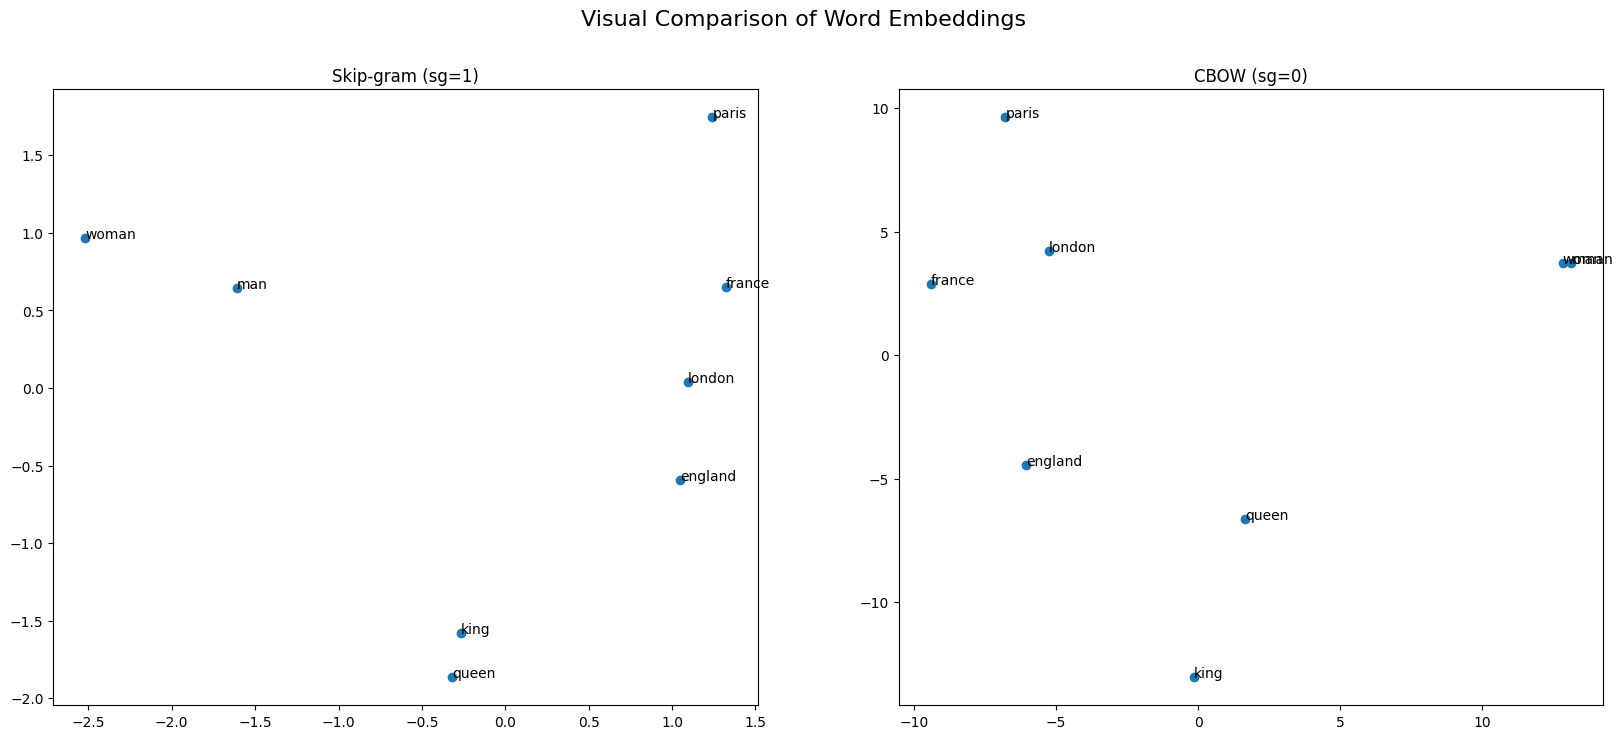

In [245]:
# --- Visual Comparison ---
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def visualize_embeddings_comparison(model_sg, model_cbow, words):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle('Visual Comparison of Word Embeddings', fontsize=16)

    # Words available in both models
    words_in_sg = [word for word in words if word in model_sg.wv]
    words_in_cbow = [word for word in words if word in model_cbow.wv]

    # --- Skip-gram Plot ---
    if words_in_sg:
        vectors_sg = [model_sg.wv[word] for word in words_in_sg]
        pca_sg = PCA(n_components=2)
        result_sg = pca_sg.fit_transform(vectors_sg)

        ax1.scatter(result_sg[:, 0], result_sg[:, 1])
        ax1.set_title('Skip-gram (sg=1)')
        for i, word in enumerate(words_in_sg):
            ax1.annotate(word, xy=(result_sg[i, 0], result_sg[i, 1]))
    else:
        ax1.set_title('Skip-gram (sg=1) - No words found')

    # --- CBOW Plot ---
    if words_in_cbow:
        vectors_cbow = [model_cbow.wv[word] for word in words_in_cbow]
        pca_cbow = PCA(n_components=2)
        result_cbow = pca_cbow.fit_transform(vectors_cbow)

        ax2.scatter(result_cbow[:, 0], result_cbow[:, 1])
        ax2.set_title('CBOW (sg=0)')
        for i, word in enumerate(words_in_cbow):
            ax2.annotate(word, xy=(result_cbow[i, 0], result_cbow[i, 1]))
    else:
        ax2.set_title('CBOW (sg=0) - No words found')

    plt.show()

# Words that might show interesting relationships
sample_words = ['king', 'queen', 'man', 'woman', 'paris', 'france', 'london', 'england']
visualize_embeddings_comparison(model, model_cbow, sample_words)

In [246]:
# --- Qualitative Comparison ---
# Let's compare the most similar words for a few terms

words_to_compare = ['king', 'woman', 'france']

for word in words_to_compare:
    print(f"--- Comparing similar words for '{word}' ---")

    # Skip-gram results
    if word in model.wv:
        similar_skipgram = model.wv.most_similar(word, topn=5)
        print(f"Skip-gram (sg=1): {[item[0] for item in similar_skipgram]}")
    else:
        print(f"Skip-gram (sg=1): Word not in vocabulary.")

    # CBOW results
    if word in model_cbow.wv:
        similar_cbow = model_cbow.wv.most_similar(word, topn=5)
        print(f"CBOW (sg=0): {[item[0] for item in similar_cbow]}")
    else:
        print(f"CBOW (sg=0): Word not in vocabulary.")
    print("\\n")

--- Comparing similar words for 'king' ---
Skip-gram (sg=1): ['canute', 'haakon', 'sweyn', 'valdemar', 'wenceslaus']
CBOW (sg=0): ['prince', 'throne', 'duke', 'emperor', 'queen']
\n
--- Comparing similar words for 'woman' ---
Skip-gram (sg=1): ['girl', 'man', 'promiscuous', 'children', 'prostitute']
CBOW (sg=0): ['child', 'girl', 'lady', 'mother', 'herself']
\n
--- Comparing similar words for 'france' ---
Skip-gram (sg=1): ['belgium', 'nantes', 'spain', 'toulouse', 'french']
CBOW (sg=0): ['spain', 'italy', 'portugal', 'belgium', 'austria']
\n


In [247]:
import pandas as pd

# Create a DataFrame to compare the evaluation scores
comparison_data = {
    "Metric": ["Word Similarity (Spearman Corr.)", "Analogy Accuracy"],
    "Skip-gram (sg=1)": [sim_score, analogy_score],
    "CBOW (sg=0)": [sim_score_cbow, analogy_score_cbow]
}
comparison_df = pd.DataFrame(comparison_data)
comparison_df.set_index("Metric", inplace=True)

print("--- Numerical Comparison ---")
print("Higher scores are better for both metrics.")
comparison_df

--- Numerical Comparison ---
Higher scores are better for both metrics.


,Skip-gram (sg=1),CBOW (sg=0)
Metric,,
Word Similarity (Spearman Corr.),NaN,NaN
Analogy Accuracy,0.125,0.0
